In [29]:
import numpy as np
import pandas as pd

import mlgrad.avragg as avragg
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.func2 as func2

from mlgrad.regr import averaging_function, regression, m_regression_irls, \
                        r_regression_irls, m_regression, \
                        plot_losses_and_errors, plot_yy, exclude_outliers

from mlgrad import erm_fg, erm_sg, erm_irgd, fg, fg_rud, sg, weights, averager_it, erisk, mrisk

from pprint import pprint

from sklearn.preprocessing import scale

import matplotlib.pyplot as plt

import sys
print(sys.version)

3.11.2 (main, Mar 13 2023, 12:18:29) [GCC 12.2.0]


In [31]:
df = pd.read_csv("data/diabets.csv", sep='\t')
X = df.values
Y = X[:,-1].copy()
X = X[:,:-1].copy()
print(X.shape, Y.shape)
print(X.dtype, Y.dtype)

print(len(Y))

Xt = scale(X)
Yt = scale(Y)


(441, 10) (441,)
float64 float64
441


In [32]:
df

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
436,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
437,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
438,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
439,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


In [33]:
def create_nn(n_input, n_layers):
    body = model.FFNetworkModel()
    n_prev_layer = n_input
    for n_layer in n_layers:
        body.add(model.LinearLayer(n_prev_layer, n_layer))
        body.add(model.ScaleLayer(func.Logistic(2.0), n_layer))
        n_prev_layer = n_layer

    head = model.LinearModel(n_layers[-1])
    ffnn = model.FFNetworkFuncModel(head, body)
    ffnn.allocate()
    return ffnn

In [34]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_sqrt = loss.ErrorLoss(func.Sqrt(1.0))

In [38]:
n_input = Xt.shape[1]
n_hidden1 = (2*n_input+1) * n_input
n_hidden2 = 2*n_input+1

n_layers = (100, 10)
print(n_input, n_hidden1, n_hidden2)

10 210 21


In [74]:
ffnn1 = create_nn(n_input, n_layers)
ffnn1.init_param()
ffnn2 = create_nn(n_input, n_layers)
ffnn2.init_param()
ffnn3 = create_nn(n_input, n_layers)
ffnn3.init_param()
ffnn4 = create_nn(n_input, n_layers)
ffnn4.init_param()
ffnn5 = create_nn(n_input, n_layers)
ffnn5.init_param()

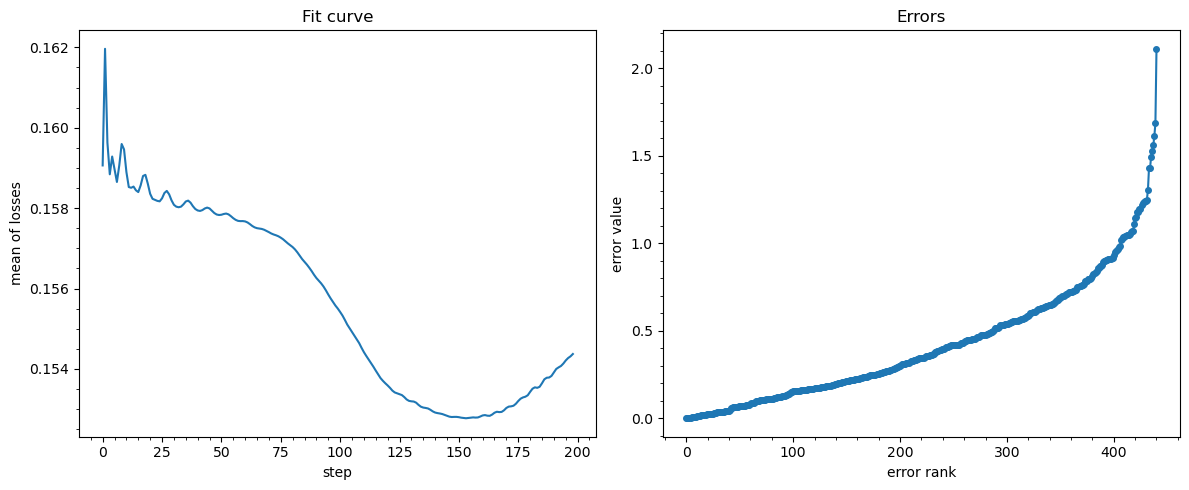

In [67]:
fg_bp = regression(Xt, Yt, ffnn1, h=0.001, tol=1.0e-8, n_restart=1)
plot_losses_and_errors(fg_bp, Xt, Yt, logscale=False)

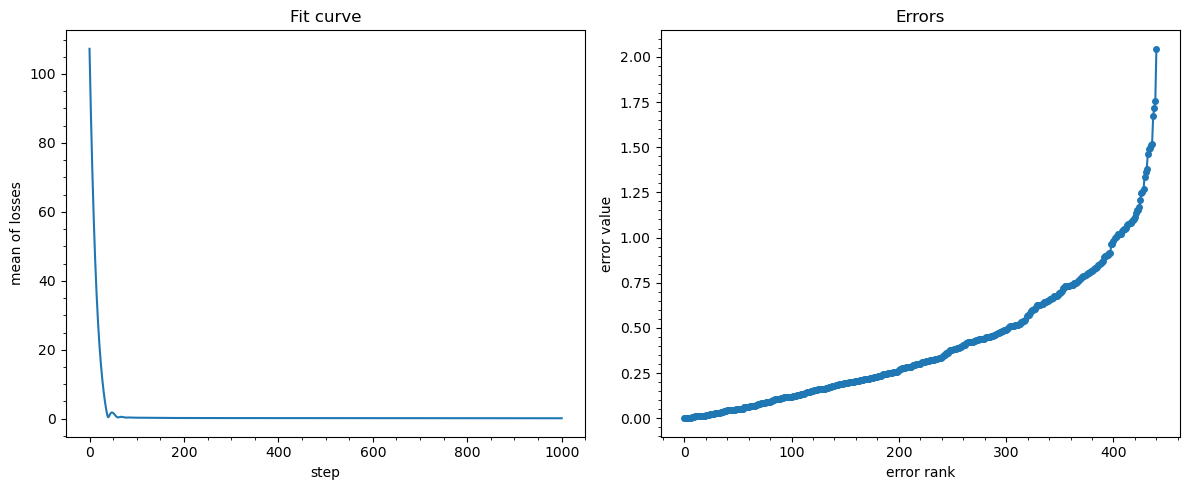

In [41]:
fg_sqrt = regression(Xt, Yt, ffnn2, loss_func=loss_func_sqrt, h=0.01, tol=1.0e-8, n_restart=1)
plot_losses_and_errors(fg_sqrt, Xt, Yt, logscale=False)

0.045167446670313104


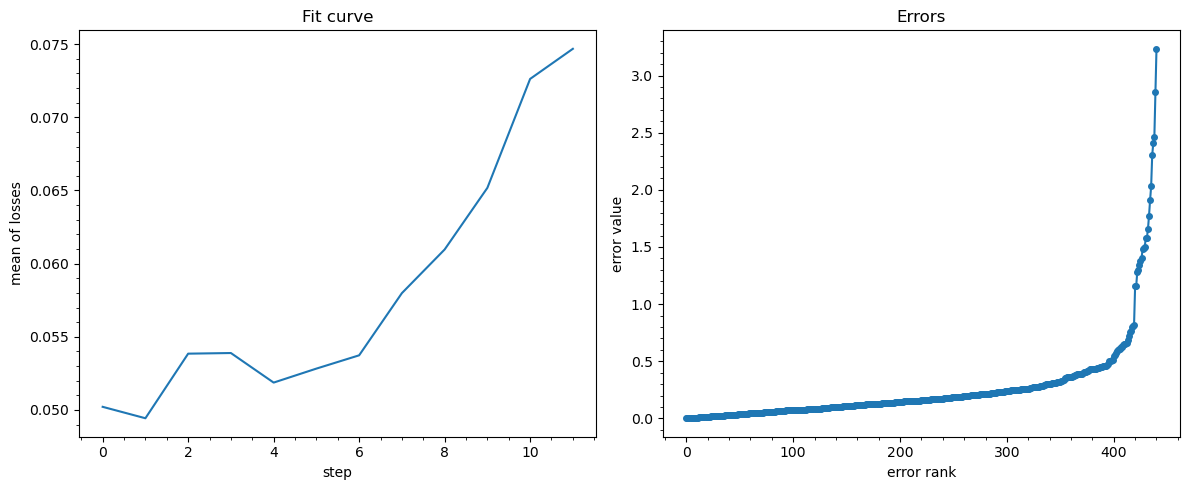

In [77]:
avg_wm = averaging_function("WM", rhofunc=func.Quantile_Sqrt(0.95, 0.01))
irgd_wm = m_regression_irls(Xt, Yt, ffnn3, agg_func=avg_wm, h=0.001, tol=1.0e-8)
plot_losses_and_errors(irgd_wm, Xt, Yt, logscale=False)

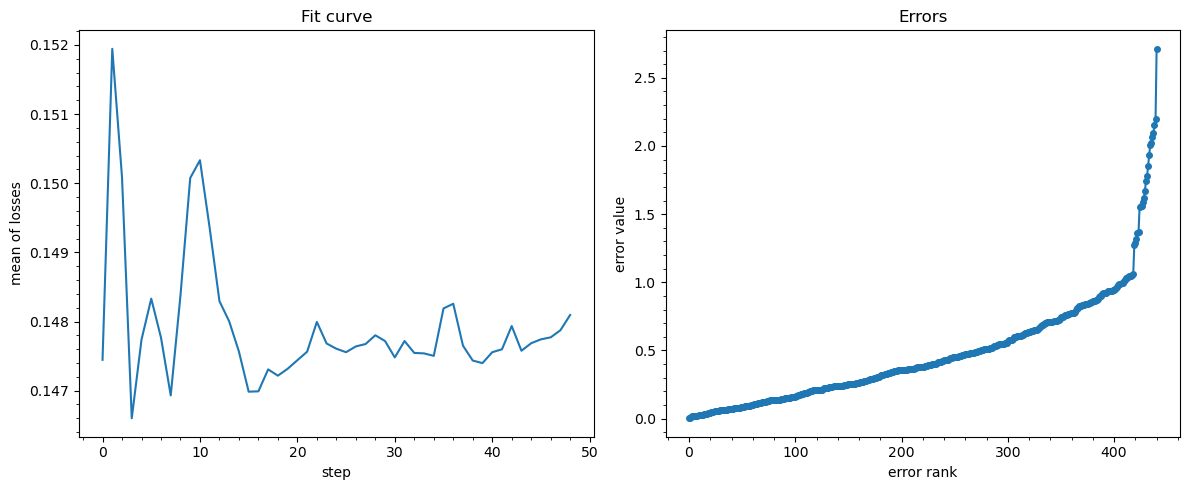

In [51]:
avg_22 = averaging_function("WM", rhofunc=func.Quantile_Sqrt(0.95, 0.001))
alg_fg2 = m_regression(Xt, Yt, ffnn4, agg_func=avg_22, h=0.001, tol=1.0e-8, n_restart=1)
plot_losses_and_errors(alg_fg2, Xt, Yt, logscale=False)

(441, 10) float64 (431, 10) float64


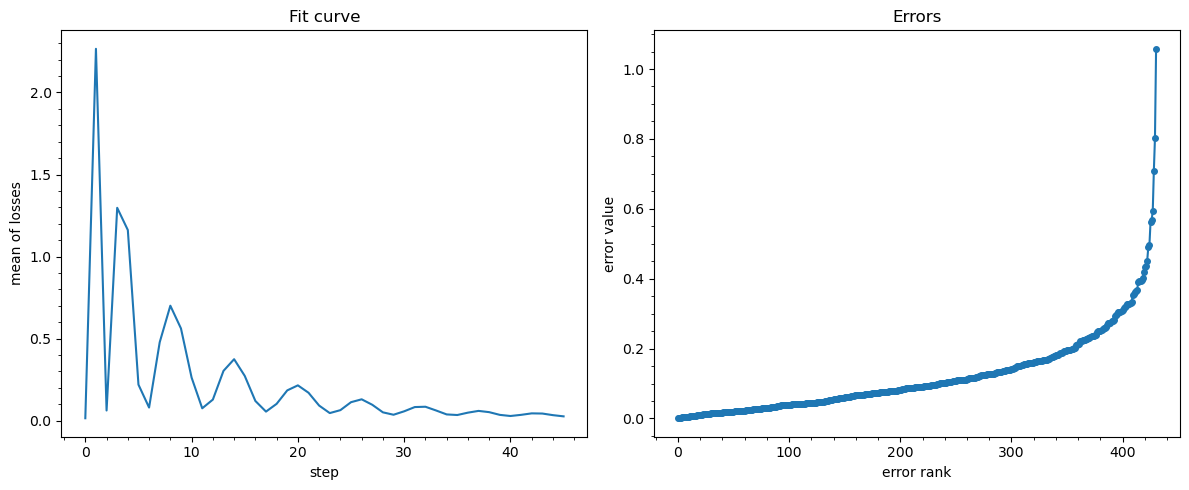

In [53]:
X_wo, Y_wo = exclude_outliers(ffnn3, Xt, Yt, 10)
print(Xt.shape, Xt.dtype, X_wo.shape, X_wo.dtype)
alg2 = regression(X_wo, Y_wo, ffnn5, h=0.01, tol=1.0e-8, n_restart=1)
plot_losses_and_errors(alg2, X_wo, Y_wo, logscale=False)

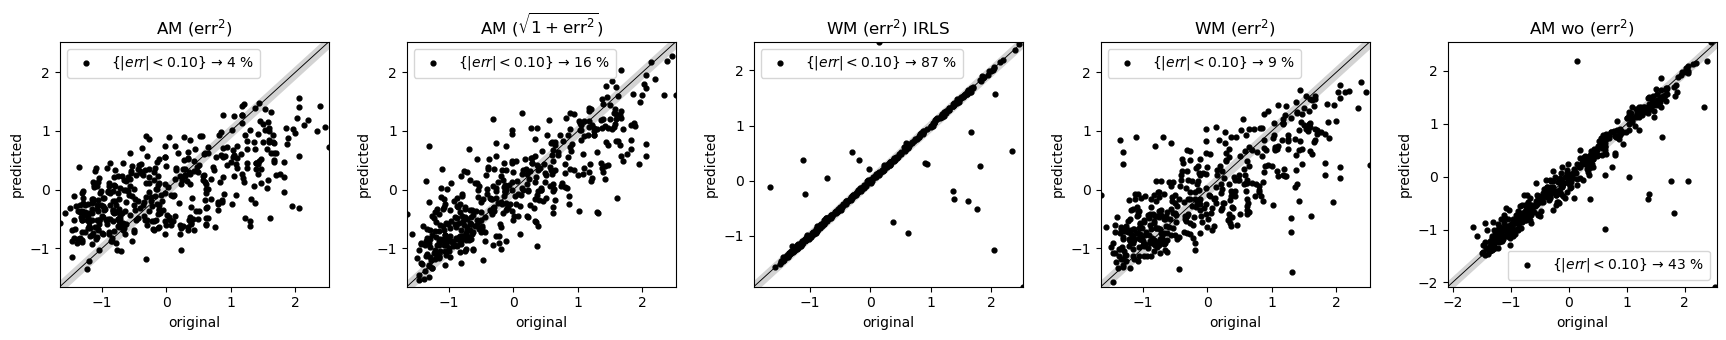

In [54]:
b=0.1
plt.figure(figsize=(5*3.5, 3.5))
plt.subplot(1,5,1)
plot_yy(Xt, Yt, ffnn1, r'AM ($\mathrm{err}^2$)', b)
plt.subplot(1,5,2)
plot_yy(Xt, Yt, ffnn2, r'AM ($\sqrt{1+\mathrm{err}^2}$)', b)
plt.subplot(1,5,3)
plot_yy(Xt, Yt, ffnn3, r'WM ($\mathrm{err}^2$) IRLS', b)
plt.subplot(1,5,4)
plot_yy(Xt, Yt, ffnn4, r'WM ($\mathrm{err}^2$)', b)
plt.subplot(1,5,5)
plot_yy(Xt, Yt, ffnn5, r'AM wo ($\mathrm{err}^2$)', b)
plt.tight_layout()
plt.show()